In [1]:
import matplotlib.pyplot as plt
import numpy as np

from nnood.network_architecture.neural_network import AnomalyScoreNetwork

In [2]:

patch_size = np.array([512, 512])
test_shape = np.array([1024, 1024])


inference_steps = AnomalyScoreNetwork.compute_steps_for_sliding_window(tuple(patch_size), test_shape, 0.5)


In [3]:
inference_steps

[[0, 256, 512], [0, 256, 512]]

In [4]:
X, Y = np.meshgrid(np.linspace(inference_steps[0][0], inference_steps[0][-1], inference_steps[0][-1] + 1),
                   np.linspace(inference_steps[1][0], inference_steps[1][-1], inference_steps[1][-1] + 1))



In [5]:
import itertools
from scipy.stats import multivariate_normal

all_steps = list(itertools.product(*inference_steps))
all_mv_norms = [multivariate_normal(np.array(c), (patch_size / 2) ** 2) for c in all_steps]

def discrete_pdf(c_1, c_2):
    point = np.array([c_1, c_2])
    res = 0.
    for mv_n in all_mv_norms:
        res += mv_n.cdf(point + 0.5)
        
        if c_1 != 0:
            res -= mv_n.cdf(point + np.array([-0.5, 0.5]))
        
        if c_2 != 0:
            res -= mv_n.cdf(point + np.array([0.5, -0.5]))
            
        if c_1 != 0 and c_2 != 0:
            res += mv_n.cdf(point - 0.5)
    
    return res
    

In [6]:
from tqdm import tqdm

Z = np.reshape(np.array([discrete_pdf(x, y) for (x, y) in tqdm(zip(X.ravel(), Y.ravel()))]), X.shape)

263169it [05:52, 747.25it/s]


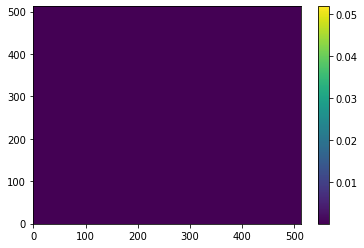

In [7]:
fig, ax = plt.subplots()

p = ax.pcolor(X, Y, Z / 9)
cb = fig.colorbar(p, ax=ax)

In [8]:
np.sum(Z) / 9

0.5980192756292673

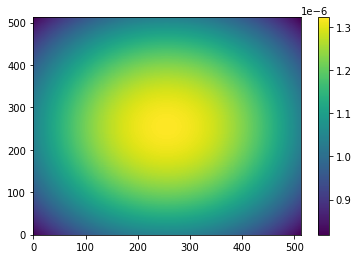

In [9]:
def discrete_pdf2(point):
    res = 0.
    for mv_n in all_mv_norms:
        res += mv_n.cdf(point + 0.5)
        
        if c_1 != 0:
            res -= mv_n.cdf(point + np.array([-0.5, 0.5]))
        
        if c_2 != 0:
            res -= mv_n.cdf(point + np.array([0.5, -0.5]))
            
        if c_1 != 0 and c_2 != 0:
            res += mv_n.cdf(point - 0.5)
    
    return res

Ps = np.dstack((X, Y))

plt.pcolor(X, Y, sum([mv.cdf(Ps + 0.5) - mv.cdf(Ps + np.array([0.5, -0.5])) - mv.cdf(Ps + np.array([-0.5, 0.5])) + mv.cdf(Ps - 0.5) for mv in all_mv_norms]) / 9)
plt.colorbar()

In [10]:
print(np.max(Z) / 9, np.min(Z) / 9)

0.05179618962247158 8.187040881901808e-07


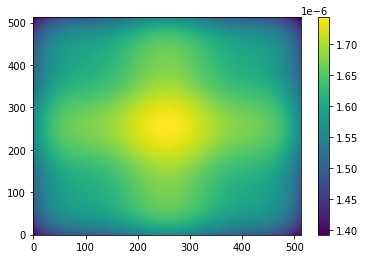

In [11]:
thinner_mv_norms = [multivariate_normal(np.array(c), (patch_size / 4) ** 2) for c in all_steps]

plt.pcolor(X, Y, sum([mv.cdf(Ps + 0.5) - mv.cdf(Ps + np.array([0.5, -0.5])) - mv.cdf(Ps + np.array([-0.5, 0.5])) + mv.cdf(Ps - 0.5) for mv in thinner_mv_norms]) / 9)
plt.colorbar()

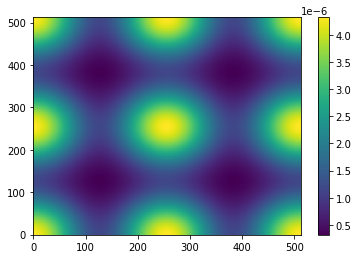

In [12]:
thinnest_mv_norms = [multivariate_normal(np.array(c), (patch_size / 8) ** 2) for c in all_steps]

Z_new = sum([mv.cdf(Ps + 0.5) - mv.cdf(Ps + np.array([0.5, -0.5])) - mv.cdf(Ps + np.array([-0.5, 0.5])) + mv.cdf(Ps - 0.5) for mv in thinnest_mv_norms]) / 9

plt.pcolor(X, Y, Z_new)
plt.colorbar()

In [13]:
print(np.max(Z_new), np.min(Z_new))

4.323062319443036e-06 3.1631973891721436e-07


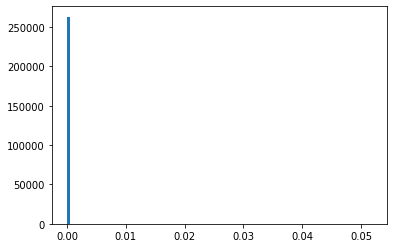

In [14]:
plt.hist((Z / 9).flatten(), bins=100)
plt.show()

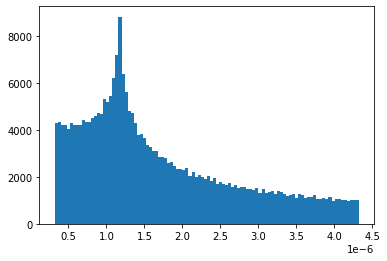

In [15]:
plt.hist(Z_new.flatten(), bins=100)
plt.show()

In [16]:
from nnood.training.dataloading.dataset_loading import sample_lb_around_step_locations

def nnUnet_uniform():
    lb = np.random.randint(test_shape - patch_size + 1)
    return lb, lb + patch_size

def sample_current_method():
    return sample_lb_around_step_locations(inference_steps, patch_size, 0, test_shape - patch_size)

# Use patch_size / 8 as std
def sample_thin_current_method():
    lb = sample_lb_around_step_locations(inference_steps, patch_size / 4, 0, test_shape - patch_size)[0]
    return lb, lb + patch_size


def sample_reflect_method():
    target_lb_mean = np.array([np.random.choice(s) for s in inference_steps])
    
    target_lb = np.random.normal(target_lb_mean, patch_size / 8).round().astype(int)
    
    max_lb = test_shape - patch_size
    
    too_low = target_lb < 0
    too_high = target_lb > max_lb
    
    while(np.logical_or(too_low, too_high).any()):
        
        # Reflect, but translate out 1 so 0 still has highest pdf
        target_lb[too_low] = -1 - target_lb[too_low]
        
        # Same, but need to index last so max_lb and target_lb elements align
        target_lb[too_high] = (max_lb - (target_lb - (max_lb + 1)))[too_high]
        
        too_low = target_lb < 0
        too_high = target_lb > max_lb

    return target_lb, target_lb + patch_size

def inference():
    lb = np.array([np.random.choice(s) for s in inference_steps])
    return lb, lb + patch_size

In [17]:
# Same number of samples as 1 epoch on chest Xray data
sample_number = 1100

methods = [
    ('Old uniform', nnUnet_uniform),
    ('Current', sample_current_method),
    ('Current thinner', sample_thin_current_method),
    ('Reflect method', sample_reflect_method),
    ('Inference', inference)]

all_samples = [(n, [m() for _ in range(sample_number)]) for n, m in methods]



Old uniform : [(0.0, 6256), (1.0, 7840), (2.0, 4821), (3.0, 6255), (4.0, 3908)]
Current : [(116.0, 65536), (121.0, 65536), (131.0, 65536), (144.0, 65536), (222.0, 65536)]
Current thinner : [(102.0, 65536), (106.0, 65536), (109.0, 65536), (125.0, 65536), (225.0, 65536)]
Reflect method : [(0.0, 1112), (1.0, 1666), (2.0, 1737), (3.0, 2579), (4.0, 2245)]
Inference : [(108.0, 65536), (122.0, 65536), (123.0, 65536), (135.0, 65536), (226.0, 65536)]


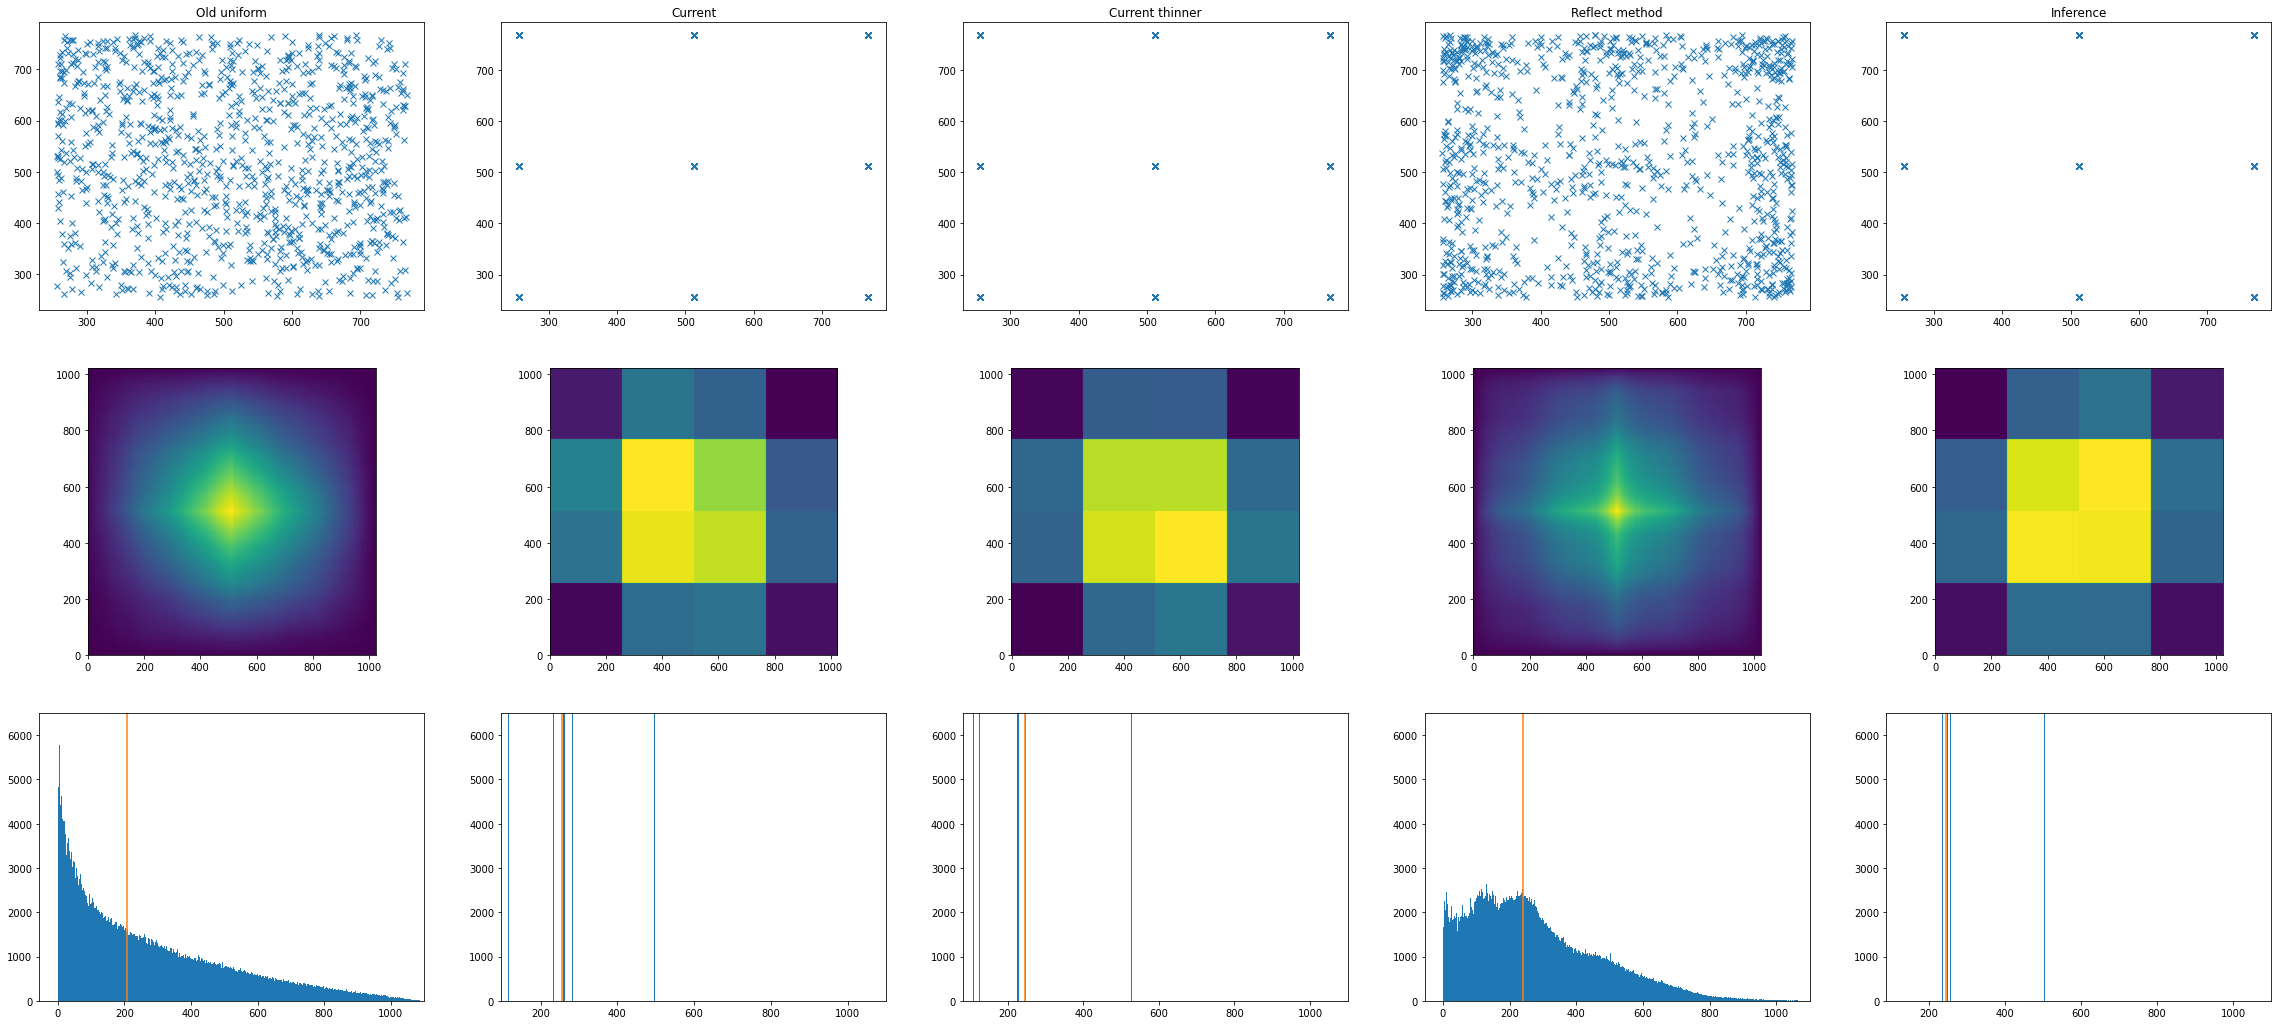

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=len(methods), figsize=(8 * len(methods), 18))

for i, (n, ss) in enumerate(all_samples):
    
    curr_data = np.array(ss).mean(axis=1)
    axes[0][i].plot(curr_data[:, 0], curr_data[:, 1], 'x')
    axes[0][i].set_title(n)
    
    curr_coverage = np.zeros(test_shape)
    
    for smin, smax in ss:
        curr_coverage[smin[1]: smax[1], smin[0]: smax[0]] += 1

    axes[1][i].imshow(curr_coverage, origin='lower')
    
    cov_flat = curr_coverage.flatten()
    cov_mean = np.median(cov_flat)
    axes[2][i].hist(cov_flat, bins=cov_flat.max().astype(int))
    axes[2][i].plot([cov_mean, cov_mean], [0, 6500])
    axes[2][i].set_ylim(top=6500)
    axes[2][i].set_xlim(right=sample_number)
    
    uniq_vals, uniq_counts = np.unique(cov_flat, return_counts=True)
    print(n, ':', list(zip(uniq_vals[:5], uniq_counts[:5])))

In [19]:
closest_step_counts = np.zeros((len(all_samples), *[len(l) for l in inference_steps]))


for i, (_, ss) in enumerate(all_samples):

    for s, _ in ss:
        
        closest_coord = [np.argmin(np.abs(np.array(steps) - c)) for c, steps in zip(s, inference_steps)]
        
        closest_step_counts[i][tuple(closest_coord)] += 1
            

122.22222222222223
59.90506893369389
14.482002453449882
14.527963669938803
11.98867778621681
8.161941187647537


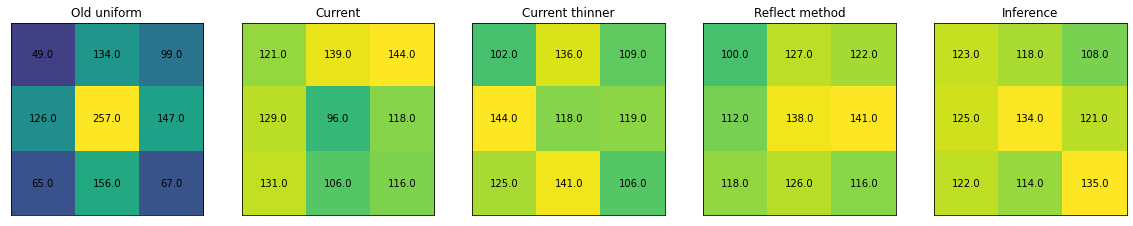

In [20]:
print(sample_number / 9)

fig, axes = plt.subplots(ncols=len(methods), figsize=(4 * len(methods), 4))

for (n, _), s_c, ax in zip(all_samples, closest_step_counts, axes):
    
    ax.set_title(n)
    ax.imshow(s_c, vmin=0)
    ax.set_xticks([])
    ax.set_yticks([])    
    
    print(np.std(s_c))
    
    for i in range(len(s_c)):
        for j in range(len(s_c[0])):
            ax.text(j, i, s_c[i, j], ha='center', va='center', color='black')#, fontweight='bold')
    
plt.show()